In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import pandas as pd
import numpy as np

### Preparing Data

In [2]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [3]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

In [4]:
import sys
sys.path.append('..')

In [5]:
from VTDA import aum

In [6]:
n_classes = len(classes)
aum = aum.AreaUnderTheMarginRanking()
training_data, reference_class_sample_idx = aum.add_reference_class_to_ds(dataset=training_data, n_class=n_classes)
n_classes += 1 

select n_reference_sample 5454


In [7]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


### Model

In [8]:
# Get cpu or gpu device for training.
device = "cuda"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, n_classes)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=11, bias=True)
  )
)


In [9]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

### Train Function

In [10]:
def train(dataloader, model, loss_fn, optimizer):

  global prediction_history ##

  size = len(dataloader.dataset)
  model.train()

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    # Compute prediction error
    pred = model(X)


    # AUM accumulation

    img_id = range(batch,batch+len(X))
    l = []
    for i in img_id:
         l.append(i)
    img_id = torch.tensor(img_id).to(device)
    aum.accumulate(pred, img_id, y)

    loss = loss_fn(pred, y)
    
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 100 == 0:
        loss, current = loss.item(), batch * len(X)
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
  
  aum.accumulate_epoch()
  aum.get_hist()


### Test Function

In [11]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

### Training & Evaluating Model

Epoch 1
-------------------------------
loss: 2.399969  [    0/60000]
loss: 2.386163  [ 6400/60000]
loss: 2.371816  [12800/60000]
loss: 2.363029  [19200/60000]
loss: 2.349915  [25600/60000]
loss: 2.325915  [32000/60000]
loss: 2.328133  [38400/60000]
loss: 2.310922  [44800/60000]
loss: 2.305516  [51200/60000]
loss: 2.267240  [57600/60000]


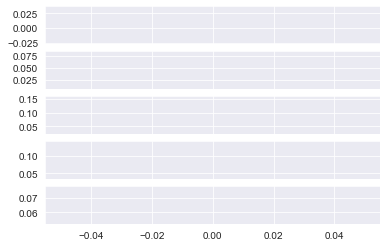

Test Error: 
 Accuracy: 47.6%, Avg loss: 2.260859 

Epoch 2
-------------------------------
loss: 2.284872  [    0/60000]
loss: 2.269359  [ 6400/60000]
loss: 2.222443  [12800/60000]
loss: 2.246355  [19200/60000]
loss: 2.215438  [25600/60000]
loss: 2.147995  [32000/60000]
loss: 2.173059  [38400/60000]
loss: 2.127107  [44800/60000]
loss: 2.117218  [51200/60000]
loss: 2.057481  [57600/60000]


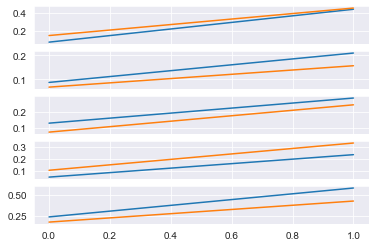

Test Error: 
 Accuracy: 56.0%, Avg loss: 2.035714 

Epoch 3
-------------------------------
loss: 2.094517  [    0/60000]
loss: 2.052944  [ 6400/60000]
loss: 1.957103  [12800/60000]
loss: 2.024578  [19200/60000]
loss: 1.965797  [25600/60000]
loss: 1.862211  [32000/60000]
loss: 1.881428  [38400/60000]
loss: 1.830015  [44800/60000]
loss: 1.819093  [51200/60000]
loss: 1.744304  [57600/60000]


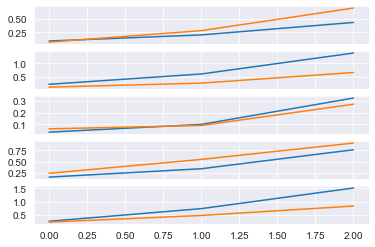

Test Error: 
 Accuracy: 60.2%, Avg loss: 1.700555 

Epoch 4
-------------------------------
loss: 1.822514  [    0/60000]
loss: 1.744175  [ 6400/60000]
loss: 1.615760  [12800/60000]
loss: 1.739531  [19200/60000]
loss: 1.689753  [25600/60000]
loss: 1.575929  [32000/60000]
loss: 1.578869  [38400/60000]
loss: 1.570765  [44800/60000]
loss: 1.554305  [51200/60000]
loss: 1.486567  [57600/60000]


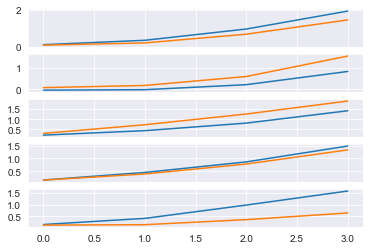

Test Error: 
 Accuracy: 62.8%, Avg loss: 1.425928 

Epoch 5
-------------------------------
loss: 1.591053  [    0/60000]
loss: 1.504602  [ 6400/60000]
loss: 1.359627  [12800/60000]
loss: 1.536909  [19200/60000]
loss: 1.498417  [25600/60000]
loss: 1.377524  [32000/60000]
loss: 1.382719  [38400/60000]
loss: 1.403026  [44800/60000]
loss: 1.379651  [51200/60000]
loss: 1.322642  [57600/60000]


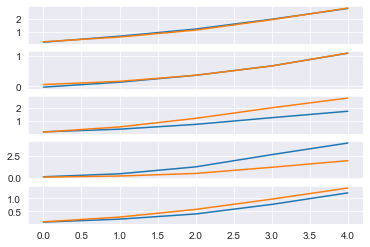

Test Error: 
 Accuracy: 64.3%, Avg loss: 1.250065 

Epoch 6
-------------------------------
loss: 1.428672  [    0/60000]
loss: 1.348324  [ 6400/60000]
loss: 1.185210  [12800/60000]
loss: 1.409506  [19200/60000]
loss: 1.373410  [25600/60000]
loss: 1.242820  [32000/60000]
loss: 1.262047  [38400/60000]
loss: 1.293712  [44800/60000]
loss: 1.262254  [51200/60000]
loss: 1.212267  [57600/60000]


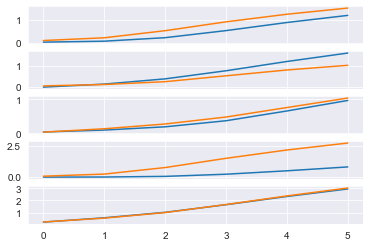

Test Error: 
 Accuracy: 65.2%, Avg loss: 1.136137 

Epoch 7
-------------------------------
loss: 1.313938  [    0/60000]
loss: 1.246336  [ 6400/60000]
loss: 1.063448  [12800/60000]
loss: 1.323434  [19200/60000]
loss: 1.291432  [25600/60000]
loss: 1.148413  [32000/60000]
loss: 1.185570  [38400/60000]
loss: 1.221642  [44800/60000]
loss: 1.179289  [51200/60000]
loss: 1.134060  [57600/60000]


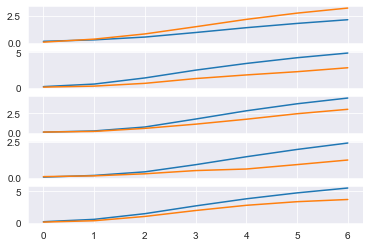

Test Error: 
 Accuracy: 66.1%, Avg loss: 1.058994 

Epoch 8
-------------------------------
loss: 1.229419  [    0/60000]
loss: 1.176810  [ 6400/60000]
loss: 0.975325  [12800/60000]
loss: 1.261537  [19200/60000]
loss: 1.236185  [25600/60000]
loss: 1.080053  [32000/60000]
loss: 1.134262  [38400/60000]
loss: 1.173062  [44800/60000]
loss: 1.118150  [51200/60000]
loss: 1.076195  [57600/60000]


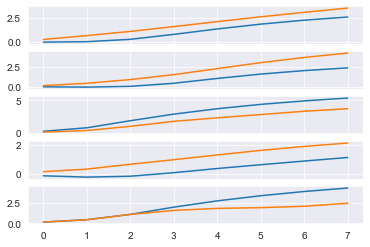

Test Error: 
 Accuracy: 67.2%, Avg loss: 1.003918 

Epoch 9
-------------------------------
loss: 1.164960  [    0/60000]
loss: 1.126044  [ 6400/60000]
loss: 0.909566  [12800/60000]
loss: 1.213939  [19200/60000]
loss: 1.197393  [25600/60000]
loss: 1.028915  [32000/60000]
loss: 1.097181  [38400/60000]
loss: 1.138610  [44800/60000]
loss: 1.072424  [51200/60000]
loss: 1.031575  [57600/60000]


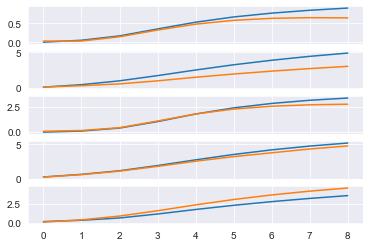

Test Error: 
 Accuracy: 68.3%, Avg loss: 0.962463 

Epoch 10
-------------------------------
loss: 1.114277  [    0/60000]
loss: 1.086062  [ 6400/60000]
loss: 0.858988  [12800/60000]
loss: 1.175718  [19200/60000]
loss: 1.168620  [25600/60000]
loss: 0.989014  [32000/60000]
loss: 1.068311  [38400/60000]
loss: 1.112537  [44800/60000]
loss: 1.036937  [51200/60000]
loss: 0.995643  [57600/60000]


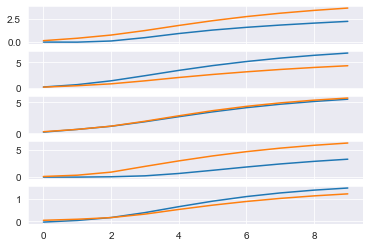

Test Error: 
 Accuracy: 69.4%, Avg loss: 0.929734 

Done!


In [12]:
epochs = 10
#print(prediction_history.shape)


for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)

print("Done!")